# Fit-Spark Classification

In [1]:
## Spark Lib
import findspark
findspark.init()

import pyspark
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.feature import StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.util import MLUtils

from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics


from pyspark.ml.feature import StringIndexer, IndexToString
from pyspark.ml.feature import VectorAssembler, VectorIndexer
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import LinearSVC, OneVsRest
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd



import pyspark.sql.functions as F
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql.types import FloatType

from pyspark.ml.linalg import Vectors
from pyspark.mllib.util import MLUtils


import time
start_time = time.time()
%matplotlib inline

# Spark Session

In [2]:
spark = SparkSession.builder \
        .master("local[*]") \
        .appName("FitSpark") \
        .getOrCreate()

# Classes

In [3]:
class Resultados:
    def __init__(self, algoritmo, acuracia, tempo, precisao, fpositivos, recall, parametroA, parametroB):
        self.algoritmo = algoritmo 
        self.acuracia = acuracia
        self.tempo = tempo
        self.precisao = precisao
        self.fpositivos = fpositivos
        self.recall = recall
        self.parametroA = parametroA
        self.parametroB = parametroB
        

        
        
class Naive:
    def __init__(self, smoothing):
        self.smoothing = smoothing 
        
class SVM:
    def __init__(self, maxIter, regParam):
        self.maxIter = maxIter 
        self.regParam = regParam
        
class Tree:
    def __init__(self, maxDepth, maxBin):
        self.maxDepth = maxDepth 
        self.maxBin = maxBin

# Funções

## Naive Bayes

In [4]:
def naive(train, test, param):
    
    best = []   # Lista do Melhor Resultado
    timeList = [] # Lista do Tempo de Treinamento de cada Modelo
    resul = [] # Lista de Todas informações na lista de Objetos
    
    start_time_total =  time.time()
  
    for x in param.smoothing:
            
        start_time =  time.time()
        
        # Define o Modelo 
        trainer = NaiveBayes(smoothing=x, modelType="multinomial")    
        evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction",\
                metricName="accuracy")
        
        # Realiza o Treinamento e Calcula Acuracia
        model = trainer.fit(train)
        result_nb = model.transform(test)
        accuracy_nb = evaluator.evaluate(result_nb) * 100
             
        timeFinal = time.time() - start_time
        timeList.append(timeFinal)
        
        print("Algorithm: Naive Bayes | Accuracy = %3.1f %% | Time = %3.1f s | Smoothing = %3.1f" % (accuracy_nb, timeFinal, x))
    
        # Matriz de Confusão
        preds_and_labels = result_nb.select(['prediction','label']).withColumn('label', F.col('label').cast(FloatType())).orderBy('prediction')
        preds_and_labels = preds_and_labels.select(['prediction','label'])
        metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))
        
        
        prec = metrics.precision(1.0) *100
        fp = metrics.falsePositiveRate(1.0)*100
        rec =  metrics.recall(1.0)*100
        
        resul.append(Resultados('naive', accuracy_nb, timeFinal, prec, fp, rec, x, None))
        
        best.append(accuracy_nb)
    
    
    timeTotal = time.time() - start_time_total

    print("Tempo Médio: %3.1f s" % (sum(timeList)/len(timeList)))
    print("Tempo Total: %3.1f s" % timeTotal)
  
    return resul


## SVM

In [5]:
def svm(train, test, param):
    
    best = []

    timeList = []

    resul = []

    start_time_total =  time.time()
    
    for x in param.maxIter:
        for y in param.regParam:
            
            start_time =  time.time()

    
            trainer = LinearSVC(featuresCol='features', labelCol='label',\
                            maxIter=x, regParam=y)

            ovr_trainer = OneVsRest(classifier=trainer)


            model = ovr_trainer.fit(train)

            result_svm = model.transform(test)


            evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction",\
                    metricName="accuracy")

            accuracy_svm = evaluator.evaluate(result_svm) * 100
            
            timeFinal = time.time() - start_time

            timeList.append(timeFinal)

            print("Algorithm: SVM | Accuracy = %3.1f %% | Time = %3.1f s | maxIter = %3.1f | regParam = %3.1f" % (accuracy_svm, timeFinal, x, y))

            # Matriz de Confusão
            preds_and_labels = result_svm.select(['prediction','label']).withColumn('label', F.col('label').cast(FloatType())).orderBy('prediction')
            preds_and_labels = preds_and_labels.select(['prediction','label'])
            metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))
        
        
            prec = metrics.precision(1.0) *100
            fp = metrics.falsePositiveRate(1.0)*100
            rec =  metrics.recall(1.0) *100
            
            
            resul.append(Resultados('svm', accuracy_svm, timeFinal, prec, fp, rec, x, y))

            
            best.append(accuracy_svm)
    
    timeTotal = time.time() - start_time_total
            
    print("Tempo Médio: %3.1f s" % (sum(timeList)/len(timeList)))
    print("Tempo Total: %3.1f s" % timeTotal)



#    return max(best)
    return resul


## Decision Tree

In [6]:
def decTree(train, test, param):
    
    best = []

    timeList = []
    
    resul = []

    start_time_total =  time.time()
    
    for x in param.maxDepth:
        for y in param.maxBin:
            
            start_time =  time.time()

    
            trainer = DecisionTreeClassifier(featuresCol='features', labelCol='label', predictionCol='prediction', probabilityCol='probability',\
                                             rawPredictionCol='rawPrediction', maxDepth=x, maxBins=y,\
                                             maxMemoryInMB=1024, cacheNodeIds=False, impurity='gini')


            evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction",\
                        metricName="accuracy")

            model = trainer.fit(train)

            result_dt = model.transform(test)
    
            accuracy_dt = evaluator.evaluate(result_dt) * 100
        
            timeFinal = time.time() - start_time
            
            timeList.append(timeFinal)
    
            #print("Decision Tree: accuracy = %3.1f %%" % accuracy_dt)
        
            print("Algorithm: decTree | Accuracy = %3.1f %% | Time = %3.1f s | maxDepth = %3.1f | maxBin = %3.1f" % (accuracy_dt, timeFinal, x, y))

            # Matriz de Confusão
            preds_and_labels = result_dt.select(['prediction','label']).withColumn('label', F.col('label').cast(FloatType())).orderBy('prediction')
            preds_and_labels = preds_and_labels.select(['prediction','label'])
            metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))
        
        
            prec = metrics.precision(1.0) *100
            fp = metrics.falsePositiveRate(1.0)*100
            rec =  metrics.recall(1.0) *100
            
            
            resul.append(Resultados('dtree', accuracy_dt, timeFinal, prec, fp, rec, x, y))
    
    timeTotal = time.time() - start_time_total
            
    print("Tempo Médio: %3.1f s" % (sum(timeList)/len(timeList)))
    print("Tempo Total: %3.1f s" % timeTotal)
    
    
#    return accuracy_dt
    return resul




## Função que Executa Todos os Algoritmos de ML

In [7]:
def autoChoice(train, test, choice, naivep, svmp, dtreep):
    
    resul=[]
    
    
    if choice == 'auto':
        resul.append(Resultados('naive' ,naive(train, test, naivep)))
        resul.append(Resultados('svm', svm(train, test, svmp)))
        resul.append(Resultados('DecisionTree', decTree(train, test, dtreep)))
        
        resul.sort(key=lambda x: x.acuracia, reverse=True)
        print(resul[0].algoritmo, resul[0].acuracia, sep =' ' )
        
        
        
    elif choice == 'naive':
        return naive(train, test, naivep)
        #print("A acurácia da Naive Bayes: %3.1f %%" % naive(train, test, naivep))
    elif choice == 'svm':
        return svm(train, test, svmp)
        #print("A acurácia da SVM: %3.1f %%" % svm(train, test, svmp))
    elif choice == 'tree':
        return decTree(train, test, dtreep)
        #print("A acurácia da Decision Tree: %3.1f %%" % decTree(train, test, dtreep))
    else:
        print("Opção Inválida")

## Função que Gera o Gráfico 2D (Apenas para Naive Bayes)

In [8]:
def graphic_2d(resul):

    x=[]
    y=[]

    for i in range(0,len(resul)):
        y.append(resul[i].acuracia)
        x.append(resul[i].parametroA)


    x = np.array(x)
    #x = range(0,len(resul))
    y = np.array(y)

    #print(y)
    
    df=pd.DataFrame({'Smoothing': x, 'Accuracy %': y })

    # Draw line chart with dashed line
    plt.plot( 'Smoothing', 'Accuracy %', data=df, linestyle='solid')

    plt.title("Iris Dataset", loc="left")
    plt.xlabel("Smoothing")
    plt.ylabel("Accuracy %")
    #plt.savefig("figura-5.png")

    # Show graph
    plt.show()

## Função que Gera o Gráfico 3D (Para SVM e Decision Tree)

In [9]:
def graphic_3d(resul):

    x=[]
    y=[]
    z=[]

    for i in range(0,len(resul)):
        x.append(resul[i].parametroA)
        y.append(resul[i].parametroB)
        z.append(resul[i].acuracia)

    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.set_title('WineQuality-Red Dataset')
    ax.set_xlabel('MaxDepth')
    ax.set_ylabel('MaxBin')
    ax.set_zlabel('Accuracy %')
    surf = ax.plot_trisurf(x, y, z, cmap=plt.cm.viridis, linewidth=0.2)
    fig.colorbar( surf, shrink=0.5, aspect=5)
    #fig.savefig("figura-9.png")
    plt.show()

# Carregamento dos Dados

In [10]:
# Datasets Marcados com "OK", são os que já estão tratados e testados

#orig_data = spark.read.format("csv").options(sep=',',header='true',inferschema='true').\
#            load('/home/tiago/Mestrado/Dissertacao/dataset/iris.data')#OK # Varia # Acuracia Maxima: 98%

#orig_data = spark.read.format("csv").options(sep=',',header='true',inferschema='true').\
#            load('/home/tiago/Mestrado/Dissertacao/dataset/glass.data') # OK # Varia # Acuracia Maxima: 80.5

#orig_data = spark.read.format("csv").options(sep=',',header='true',inferschema='true').\
#            load('/home/tiago/Mestrado/Dissertacao/dataset/sonar.data')#OK # Varia # Acuracia Maxima: 77.8

#orig_data = spark.read.format("csv").options(sep=',',header='true',inferschema='true').\
#            load('/home/tiago/Mestrado/Dissertacao/dataset/breast-cancer-wisconsin.data')#OK # Estatico

#orig_data = spark.read.format("csv").options(sep=',',header='true',inferschema='true').\
#            load('/home/tiago/Mestrado/Dissertacao/dataset/lymphography.data')#OK # Estatico

#orig_data = spark.read.format("csv").options(sep=',',header='true',inferschema='true').\
#            load('/home/tiago/Mestrado/Dissertacao/dataset/balance-scale.data')#OK # Estatico

#orig_data = spark.read.format("csv").options(sep=',',header='true',inferschema='true').\
#            load('/home/tiago/Mestrado/Dissertacao/dataset/balance-scale2.data')#OK # Estatico

#orig_data = spark.read.format("csv").options(sep=',',header='true',inferschema='true').\
#            load('/home/tiago/Mestrado/Dissertacao/dataset/ecoli.data')#

#orig_data = spark.read.format("csv").options(sep=',',header='true',inferschema='true').\
#            load('/home/tiago/Mestrado/Dissertacao/dataset/wine-white.data')#

#orig_data = spark.read.format("csv").options(sep=',',header='true',inferschema='true').\
#            load('/home/tiago/Mestrado/Dissertacao/dataset/wine-red.data')# ESSE É WHITE: Accuracy = 62.2 %

orig_data = spark.read.format("csv").options(sep=',',header='true',inferschema='true').\
            load('/home/tiago/Mestrado/Dissertacao/dataset/wine-white.data')# ESSE É RED

# Parâmetros

In [11]:
train_sample = 0.7
test_sample = 0.3

# 'auto'  = Testa tudo
# 'tree'  = Decision Tree
# 'naive' = Naive Bayes
# 'svm'   = SVM
choice = 'tree'

# Parâmetros Naive
# Nome = Smoothing
#smoothing = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
smoothing = [round(x * 0.1, 1) for x in range(0, 100)]

#smoothing = [1, 2, 3]
naiveParam = Naive(smoothing)

# Parâmetros SVM
maxIter = [80,90,100]
regParam = [0.1,0.2,0.3]
svmParam = SVM(maxIter, regParam)

# Parâmetros Decision Tree
# Deapht / MaxIter
maxDepth = [x for x in range(1, 31)] # 31 é o máximo
maxBin = [32,64,128,256,512,1024]
dtreeParam = Tree(maxDepth, maxBin)

################


#amostra = ""
#execucao = "dtree-MD-custom-30-40-CP-custom-15-30"

# Pré-Processamento/Tratamento Padrão

In [12]:
indexer = StringIndexer(inputCol="class", outputCol="label").fit(orig_data)
label_data = indexer.transform(orig_data)

labelReverse = IndexToString().setInputCol("label")

label_data = label_data.drop("class")

ignore = ['label']
list = [x for x in label_data.columns if x not in ignore]

assembler = VectorAssembler(
            inputCols=list,
            outputCol='features')

data = (assembler.transform(label_data).select("label","features"))


# RandomSplit Train/Test

In [13]:
(train, test) = data.randomSplit([train_sample, test_sample], 1234)

In [14]:
resul = []
resul = autoChoice(train, test, choice, naiveParam, svmParam, dtreeParam)

Algorithm: decTree | Accuracy = 45.0 % | Time = 4.2 s | maxDepth = 1.0 | maxBin = 32.0
Algorithm: decTree | Accuracy = 45.0 % | Time = 2.0 s | maxDepth = 1.0 | maxBin = 64.0
Algorithm: decTree | Accuracy = 45.0 % | Time = 1.5 s | maxDepth = 1.0 | maxBin = 128.0
Algorithm: decTree | Accuracy = 45.0 % | Time = 1.1 s | maxDepth = 1.0 | maxBin = 256.0
Algorithm: decTree | Accuracy = 45.0 % | Time = 1.1 s | maxDepth = 1.0 | maxBin = 512.0
Algorithm: decTree | Accuracy = 45.0 % | Time = 1.1 s | maxDepth = 1.0 | maxBin = 1024.0
Algorithm: decTree | Accuracy = 50.3 % | Time = 1.2 s | maxDepth = 2.0 | maxBin = 32.0
Algorithm: decTree | Accuracy = 51.3 % | Time = 1.6 s | maxDepth = 2.0 | maxBin = 64.0
Algorithm: decTree | Accuracy = 51.3 % | Time = 1.1 s | maxDepth = 2.0 | maxBin = 128.0
Algorithm: decTree | Accuracy = 51.3 % | Time = 1.1 s | maxDepth = 2.0 | maxBin = 256.0
Algorithm: decTree | Accuracy = 51.3 % | Time = 1.1 s | maxDepth = 2.0 | maxBin = 512.0
Algorithm: decTree | Accuracy = 51.

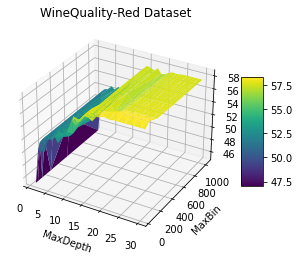

In [15]:
#graphic_2d(resul)
graphic_3d(resul)


In [16]:
# Exibe os Melhores Resultados em Ordem Decrescente
resul.sort(key=lambda x: x.acuracia, reverse=True)
for i in range(10):
    print("Algorithm: %s | Accuracy = %3.1f %% | Time = %3.1f s | Smoothing = %3.1f" % (resul[i].algoritmo, resul[i].acuracia, resul[i].tempo, resul[i].parametroA))

Algorithm: dtree | Accuracy = 58.6 % | Time = 5.9 s | Smoothing = 22.0
Algorithm: dtree | Accuracy = 58.6 % | Time = 7.1 s | Smoothing = 23.0
Algorithm: dtree | Accuracy = 58.6 % | Time = 5.6 s | Smoothing = 24.0
Algorithm: dtree | Accuracy = 58.6 % | Time = 5.8 s | Smoothing = 25.0
Algorithm: dtree | Accuracy = 58.6 % | Time = 6.3 s | Smoothing = 26.0
Algorithm: dtree | Accuracy = 58.6 % | Time = 6.7 s | Smoothing = 27.0
Algorithm: dtree | Accuracy = 58.6 % | Time = 7.8 s | Smoothing = 28.0
Algorithm: dtree | Accuracy = 58.6 % | Time = 5.4 s | Smoothing = 29.0
Algorithm: dtree | Accuracy = 58.6 % | Time = 5.8 s | Smoothing = 30.0
Algorithm: dtree | Accuracy = 58.5 % | Time = 5.6 s | Smoothing = 21.0


In [17]:
# Imprime Outros Resultados do Melhor Modelo
print("Algorithm: %s | Precisão = %3.1f %% | False Positive = %3.1f %% | Recall = %3.1f %%" % (resul[0].algoritmo, resul[0].precisao, resul[0].fpositivos, resul[0].recall))

Algorithm: dtree | Precisão = 60.0 % | False Positive = 16.2 % | Recall = 59.2 %
